<a href="https://colab.research.google.com/github/kamilest/oxwocs-girls-who-ml-2021/blob/main/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Girls Who ML Session 1: Linear regression

In [1]:
import numpy as np
import pandas as pd
import sklearn 

import matplotlib.pyplot as plt

In [73]:
#@title Helper functions

def plot_iris_dataset(a=None, b=None, model=None, residuals=False, savefig=False, figname=None):
  plt.scatter(iris_data.data, iris_data.target, zorder=0)
  
  x = np.linspace(0, 8, 100).reshape(-1, 1)
  if model:
    plt.plot(x, model.predict(x), c='orange', zorder=0)
  elif a is not None and b is not None:
    plt.plot(x, a * x + b, c='orange', zorder=0)
  
  if residuals:
    X = iris_data.data.reshape(-1, 1)
    y = iris_data.target
    if model:
      y_pred = model.predict(X)
    elif a is not None and b is not None:
      y_pred = a * X + b
    plt.vlines(X, y, y_pred, colors='red', zorder=1)
  
  plt.xlabel("petal length (cm)")
  plt.ylabel("petal width (cm)")
  plt.xlim([-0.25, 8.25])
  plt.ylim([-0.25, 2.75])

  if savefig:
    plt.savefig('{}.png'.format(figname if figname else 'figure'), dpi=600)

  plt.show()

def plot_iris_dataset_with_line(a, b, residuals=False):
  plot_iris_dataset(a=a, b=b, residuals=residuals)

# Introduction

In the first class we will be learning about one of the simplest (yet still one of the most important) machine learning algorithms called **linear regression**, which is used for linear models.

## Simple linear model

In a linear model, we assume that the dependent variable (aka the response variable, target, or label) we want to predict can be obtained through a *linear transformation* of the independent variables (aka predictor variables, covariates, or features).

When we have only one feature, the linear model reduces to the equation of a line, which we are all familiar with:

$$y = ax + b$$

Here the feature is denoted by $x$, and the label by $y$, and $(a, b)$ are the *parameters* of the model.

The goal of the *linear regression* method, then, is to obtain the coefficients $(a, b)$ that best model the data (our features and labels). We explore how this is done in detail through an example below.

# The dataset

We will be using a subset of the [iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) with just 15 points, predicting the petal width from petal length of iris flowers.

Here is some code to load the dataset—we extract the petal widths into an array called `petal_width` and petal lengths into `petal_length` (don't worry about the details of the remaining code). 

In [66]:
from sklearn.utils import Bunch
from sklearn.datasets import load_iris

dataset = load_iris()
sample = [ 57, 122, 118,  53, 117,  81,  70, 142,  84,  16, 103,  82,  66, 31,  83]

petal_length = np.take(dataset.data[:, 2], sample)
petal_width = np.take(dataset.data[:, 3], sample)
iris_data = Bunch(data=petal_length, target=petal_width)

We can print the values of our feature variable for all data points:

In [60]:
petal_length

array([3.3, 6.7, 6.9, 4. , 6.7, 3.7, 4.8, 5.1, 4.5, 1.3, 5.6, 3.9, 4.5,
       1.5, 5.1])

And the corresponding labels:

In [61]:
petal_width

array([1. , 2. , 2.3, 1.3, 2.2, 1. , 1.8, 1.9, 1.5, 0.4, 1.8, 1.2, 1.5,
       0.4, 1.6])

While the above format is more convenient for most machine learning tasks, we can also print the data points in the form $(x_i, y_i)$, where $x_i$ is the feature (petal length) and $y_i$ is the label (petal width) of observation $i$. For a single observation $i$, we could do it like this:

In [65]:
i = 0
petal_length[i], petal_width[i]

(3.3, 1.0)

Or we could print all the data points in this way at the same time:



In [ ]:
list(zip(petal_length, petal_width))

Finally, the most convenient way to explore a dataset is, of course, to visualise it!

In this notebook, we can use the magic  `plot_iris_dataset()` method:

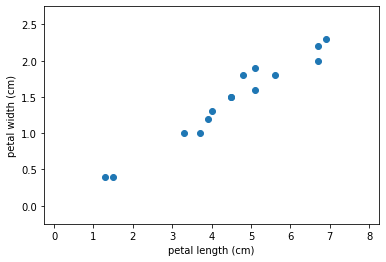

In [64]:
plot_iris_dataset()

# Fitting a simple linear model

Recall that our model is of the form 

$$y = ax + b$$

or, in our case of the iris dataset,

$$\text{petal_width} = a \cdot \text{petal_length} + b$$

for some unknown $a$ and $b$. Our goal today will be to find the best line (parameterised by $a$ and $b$) which fits our dataset the best.

## Task 1: experimenting with lines

First, let's experiment with some possible values for $a$ and $b$. You can try out some lines using another magic plotting function, and setting different values for `a` and `b`.

*Can you find a line that best matches the data?*



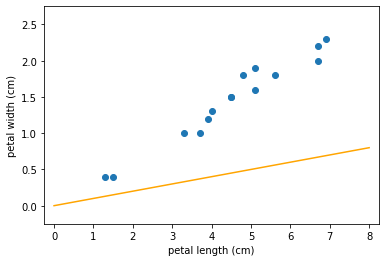

In [81]:
a = 0.1
b = 0
plot_iris_dataset_with_line(a, b)

# Quantifying the residuals

How could you tell whether one line you tried was better than another? It is likely you used some notion of "closeness" of the line you estimated to the data points. For example, this line:

![](https://raw.githubusercontent.com/kamilest/oxwocs-girls-who-ml-2021/main/images/bad_line.jpeg)

probably looks worse than this line:

![](https://raw.githubusercontent.com/kamilest/oxwocs-girls-who-ml-2021/main/images/better_line.jpeg)

Can we quantify this error? The answer is yes, and we will do this using *residuals*. 

The residual is nothing but the *difference* between the value predicted by the model, $\hat{y}_i$, and the ground truth value $y_i$ for some observation $i$. For the data points in the iris dataset, we can visualise the residuals (the differences between the petal widths predicted by the line and the petal widths in the dataset) as follows:






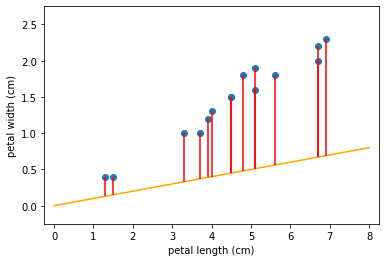

In [82]:
plot_iris_dataset_with_line(a=0.1, b=0, residuals=True)

where the residuals are shown with the red lines. You can see that the total length of the red lines above is larger than in the following plot:

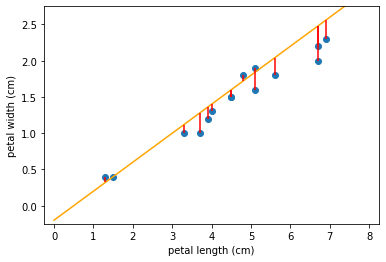

In [83]:
plot_iris_dataset_with_line(a=0.4, b=-0.2, residuals=True)

However, since we normally do not care about whether the error comes from the point being above or below the line, and for the penalty to scale faster for very large distances, we will square the value of the residual:

$$ (\hat{y}_i - y_i)^2$$

and, to account for all the information in the dataset, we will compute the average of the squared residuals for all points:

$$ \frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i)^2$$

which is, in fact, one of the most popular *loss functions*, or *performance measures*, in machine learning called the *mean squared error* (MSE).

## Task 2: computing MSE

The second task will ask you to write a function to compute the mean squared error of a given line for the iris dataset.

Recall that $\hat{y}_i$ is the prediction of the model $\hat{y}_i = a x_i + b$, where $x_i$ denotes the *petal length*, $y_i$ denotes the *petal width*, and all $x_i$ and $y_i$ can be accessed through `petal_length[i]` and `petal_width[i]` respectively.

The final expression for the mean squared error is therefore

$$ \frac{1}{N} \sum_{i=1}^N (a x_i + b - y_i)^2$$


In [89]:
def mean_squared_error(a, b):
  # TODO: write some code here
  mse = None

  return mse

Verify that your answer is correct by checking that

`mean_squared_error(0.1, 0)` returns around 21.466 and

`mean_squared_error(0.4, -0.2)` returns around 18.959.

`sklearn` linear regression

In [8]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X=iris_data.data.reshape(-1, 1), y=iris_data.target)
print("Coefficient: {}, intercept: {}".format(reg.coef_[0], reg.intercept_))

Coefficient: 0.3397874212984903, intercept: -0.07130864531852943


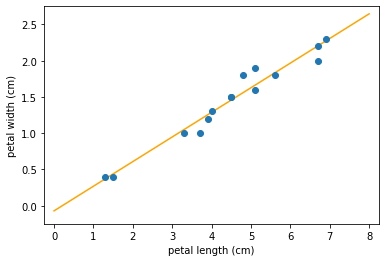

In [12]:
plot_iris_dataset(model=reg)

Residuals

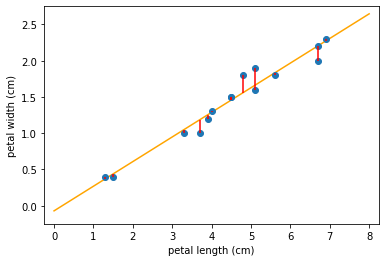

In [18]:
plot_iris_dataset(model=reg, residuals=True)

Residuals for a different slope

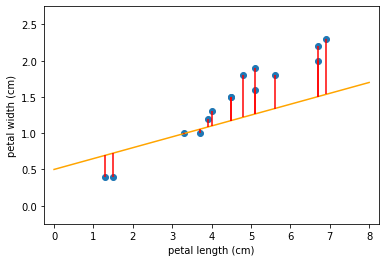

In [24]:
plot_iris_dataset(a=0.15, b=0.5, residuals=True)

In [34]:
next(zip(aa, bb))

(0.15, 0.7)

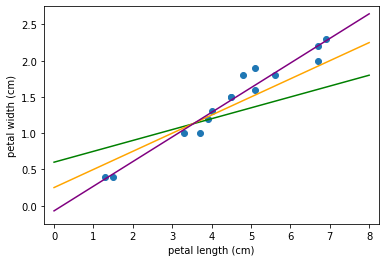

In [55]:
plt.scatter(iris_data.data, iris_data.target, zorder=0)
  
x = np.linspace(0, 8, 100).reshape(-1, 1)
aa = [0.15, 0.25, 0.3397874212984903]
bb = [0.6, 0.25, -0.07130864531852943]
cc = ['green', 'orange', 'purple']

for (a, b, c) in zip(aa, bb, cc):
  plt.plot(x, a * x + b, c=c, zorder=0)

plt.xlabel("petal length (cm)")
plt.ylabel("petal width (cm)")
plt.xlim([-0.25, 8.25])
plt.ylim([-0.25, 2.75])

plt.savefig('difflines.png', dpi=600)

plt.show()

# Gradient descent

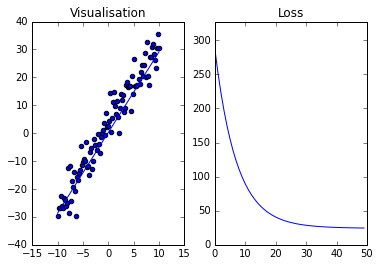

2.8910643607910256 0.2580041932818179


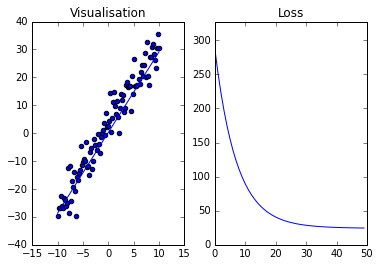

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display



plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


def generate_data(num_samples, x_lower_lim=-10, x_upper_lim=10):
    """
    @param num_samples number of samples to generate.
    @x_lower_lim lower limit for x
    @x_upper_lim upper limit for x
    This function generates the ground truth data.
    In real life we do not know the function below,
    but we will try and approximate it using MLE or MAP.
    """
    x = np.linspace(x_lower_lim, x_upper_lim, num_samples)
    y = 3 * x + 2 
    w = 4 * np.random.randn(num_samples) + 0
    y = y + w
    return x, y



class LinearRegression():
    def __init__(self, init_a, init_b):
        """
        This function is called initially, allowing us
        to set member variables for the class.
        @param init_a initiliasation for a
        @param init_b initiliasation for b
        """
        self.a = init_a
        self.b = init_b

    def _calc_gradient_at_x(self, x, y):
        """
        Calculates the gradients of the loss function
        wrt to the parameters at position x.
        """
        # y_pred = self.a * x + self.b        
        # grad_a = -2 * (x * (y - y_pred)).mean()
        # grad_b = -2 * (y - y_pred).mean()
        # return grad_a, grad_b

    def step(self, lr, x, y):
        """
        Updates the parameters.
        """
        # grad_a, grad_b = self._calc_gradient_at_x(x, y)
        # self.a = self.a - lr * grad_a
        # self.b = self.b - lr * grad_b

    def calc_loss(self, x, y):
        """
        Calculates the loss.
        """
        # return ((y - self.a * x - self.b)**2).mean()

    def set_up_vis(self, num_steps, x):
        self.losses = []
        self.steps = []
        self.pred_line, = ax1.plot(x, self.a * x + self.b, 'b-')
        ax2.plot(self.steps, self.losses, 'b-')
        ax2.set_xlim([0, num_steps])
        ax2.set_ylim([0, self.calc_loss(x, y)])

    def update_vis(self, x, y, step):
        self.losses.append(self.calc_loss(x, y))
        self.steps.append(step)
        del ax2.lines[-1]
        ax2.plot(self.steps, self.losses, 'b-')
        self.pred_line.set_ydata(self.a * x + self.b)
        fig.canvas.draw()
        fig.canvas.flush_events()
        display.clear_output(wait=True)
        display.display(plt.gcf())


    def train(self, num_steps, lr, x, y):
        """
        Training loop
        """
        self.set_up_vis(num_steps, x)
        for i in range(int(num_steps)):
            self.step(lr, x, y)
            self.update_vis(x, y, i)
            


x, y = generate_data(100)
ax1.scatter(x, y)
ax1.set_title("Visualisation")
ax2.set_title("Loss")


linear_regression = LinearRegression(0, 0)

grads = linear_regression.train(50, 1e-3, x, y)
print(linear_regression.a, linear_regression.b)
